<h1  style = "font-size:30px;background-color: White ; color : Black; text-align: center; border-radius: 20px 20px; text-decoration: underline; font-style : italic;">🛫 Anomaly detection during aircraft flights 🛫</h1>

An aircraft system expert would like us to *build an algorithm to detect windows that are abnormal*.  
During aircraft flights, many measures are recorded on parameters such as speed, temperature and others to ensure that the system works well.  
Such as the image below, we can see that a measure is executed according to a day, a cycle and a window.


<figure>
  <img src="aircraft window.png"  style="width:75%;display:block;margin-left:auto;margin-right:auto;">
  <figcaption style="text-align: center">Fig.1 - Measure of the aircraft system.</figcaption>
</figure>

With the few informations above and the dataset given we gonna study, the aim is to formulate the problem we are facing, develop an approach to answer it and present our findings.

<h1  style = "font-size:30px; color : Blue; text-align: left;"> 📜 1. Dataset analyzing</h1>

First and foremost, let's begin by analyzing the dataset we have in order to determine what kind of procedure we will execute.

Let's import all the libraries we'll need.

In [43]:
# Librairies basiques de python
from typing import Callable, Dict, List, Optional, Tuple, Union

# Importation des librairies de machine learning
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns


from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

To begin with, let's check the shape of our dataset.

In [44]:
df = pd.read_csv("dataset.csv")
print(df)
print(f'This dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

       day_cycle_window        p1        p2        p3        p4        p5  \
0                 1_1_1 -0.805191 -1.141993 -1.328327 -1.516693 -1.373962   
1                 1_1_1 -0.805191 -1.134902 -1.320393 -1.505848 -1.361560   
2                 1_1_1 -0.805191 -1.117304 -1.307167 -1.505848 -1.361560   
3                 1_1_1 -0.814231 -1.114206 -1.287593 -1.442302 -1.287565   
4                 1_1_1 -0.848104 -1.112276 -1.285393 -1.429076 -1.270722   
...                 ...       ...       ...       ...       ...       ...   
162697          4_4_160  0.147741  0.060913  0.185874 -0.163053 -0.284814   
162698          4_4_160  0.147741  0.060913  0.185874 -0.163053 -0.284814   
162699          4_4_160  0.147741  0.060913  0.185874 -0.163053 -0.284814   
162700          4_4_160  0.147741  0.060913  0.185874 -0.163053 -0.232045   
162701          4_4_160  0.196873  0.090617  0.292064 -0.132991 -0.219665   

              p6        p7        p8        p9       p10       p11  
0     

As we can see above, The dataset has 12 columns and one of them represents all the measures taken during a flight. We want to know how many window we have and if there are null data.

In [45]:
#dataframe grouped by windows
nb_window = df.groupby(['day_cycle_window']).count()
print(f'This dataset contains {nb_window.shape[0]} different windows.')

This dataset contains 1637 different windows.


In [46]:
#Number of NaN by columns
nb_na = df.isna().sum().sum()
print(f'This dataset has a total of {nb_na} NaN values.')

This dataset has a total of 0 NaN values.


Finally, we have to verify if all the windows have a total of 100 measures each. With what we've done before, we know the `nb_window` variable is a dataframe where we have the total number of each window and for each column. 

In [47]:
#Number of windows where there less than 100 measures
comp = 0
for i in range(len(nb_window)):
    # If the total number is different from 100, we print the name of the window and its number of measure
    if nb_window.iloc[i,0] != 100:
        print(f'The window {nb_window.index[i]} has {nb_window.iloc[i,0]} data.')
        comp += 1
print(f'{comp} windows have less than 100 measures.')

The window 1_1_68 has 75 data.
The window 1_2_181 has 3 data.
The window 1_3_6 has 53 data.
The window 1_4_17 has 50 data.
The window 1_5_94 has 17 data.
The window 2_1_181 has 2 data.
The window 2_2_76 has 62 data.
The window 2_3_145 has 32 data.
The window 3_1_181 has 3 data.
The window 3_2_52 has 17 data.
The window 3_3_181 has 2 data.
The window 4_1_49 has 85 data.
The window 4_2_181 has 3 data.
The window 4_3_65 has 22 data.
The window 4_4_160 has 76 data.
15 windows have less than 100 measures.


⚠️These 15 windows can be considered as anomalies. Indeed, during a flight, we should have 100 measures for each one. But in the cases presented above, we don't have the required number. A deeper analysis must be executed on these measures by people who has taken them in order to know what happened.

Finally, we separate our dataset in two datasets.

In [48]:
#Dataset with a number of window different from 100
bad_df = df.groupby('day_cycle_window').filter(lambda x: x['day_cycle_window'].count()!=100)

#Dataset with the great amount of measures by window
new_df= df.groupby('day_cycle_window').filter(lambda x: x['day_cycle_window'].count()==100)
new_df

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.808270,-1.070547,-0.504352,2.807146,0.495528,-1.246737
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.807840,-1.064212,-0.516000,2.894177,0.494467,-1.244472
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.807840,-1.064212,-0.516000,2.981904,0.429370,-1.244472
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.807840,-1.045557,-0.516000,3.063298,0.348056,-1.244472
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.807840,-1.017575,-0.664906,3.049237,0.118828,-1.270237
...,...,...,...,...,...,...,...,...,...,...,...,...
162621,4_4_159,-0.966581,-1.312164,-1.272253,-1.466330,-1.263788,-0.788875,-1.156878,-1.027211,0.720963,1.694134,-0.690193
162622,4_4_159,-0.969980,-1.311966,-1.277075,-1.471689,-1.263653,-0.788875,-1.156878,-1.027211,0.716483,1.694134,-0.690193
162623,4_4_159,-0.975743,-1.311966,-1.284710,-1.471689,-1.263439,-0.788875,-1.156878,-1.027211,0.710676,1.698656,-0.690193
162624,4_4_159,-0.981632,-1.311966,-1.284710,-1.471689,-1.263439,-0.788875,-1.156878,-1.027211,0.710676,1.704900,-0.690193


Here, we show the statistics about the different columns of our dataset.

In [49]:
new_df.describe()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
count,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000
mean,0.000396,-0.000680,-0.002286,-0.000366,-0.000363,0.000805,0.000823,0.000291,0.002817,-0.001299,-0.002914
std,0.999141,0.998478,0.995442,0.998792,0.998532,0.998860,0.999383,0.999187,0.992008,0.987465,0.994999
min,-3.211980,-3.395387,-3.325651,-3.378450,-3.281286,-4.200181,-3.898025,-3.524957,-13.704556,-10.621700,-3.183571
25%,-0.678808,-0.482556,-0.629276,-0.491163,-0.611638,-0.559023,-0.605228,-0.737095,-0.590086,-0.499300,-0.658530
50%,0.042896,0.179877,0.040733,0.147397,0.117040,0.154443,0.186879,-0.011674,-0.032984,-0.257635,-0.016261
75%,0.743797,0.655579,0.656998,0.636887,0.711965,0.684938,0.719222,0.802395,0.508989,0.357578,0.633398
max,5.013899,6.260782,8.652950,8.359670,6.424227,5.638259,3.735957,4.667058,8.203706,5.597387,9.204384


<h1  style = "font-size:30px; color : Blue; text-align: left;"> 📊 2. Detection of anomalies </h1>

Let's talk about the detection of anomalies.  
As we can see below, we have the same graph. However,There are many ways of interpreting it. If we are looking for anomalies which differ from the majority of the data, then we are doing an **outlier detection** such as Fig 2.  
However, in the Fig 3, we have a **Novelty detection**. It learns the normal behavior of the dataset. Then, it can detect if a new item is normal or an anomaly.

<table> 
	<tr> 
		<td><img src="outliers.png" style="background-color:White;"><figcaption style="text-align: center">Fig.2 - Outlier detection.</figcaption></td> 
		<td><img src="anomalies.png" style="background-color:White;"><figcaption style="text-align: center">Fig.3 - Novelty detection.</figcaption></td> 
	</tr> 
</table> 

We don't have new data.  
In addition, we don't have much information on the dataset and we don't know the parameters associated to each column.  
So, with not much information, we should proceed with an **outlier detection** and find data which differ from the majority.

In [50]:
#Isolation of the windows
window = new_df['day_cycle_window']

new_df.drop('day_cycle_window', axis = 1)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.808270,-1.070547,-0.504352,2.807146,0.495528,-1.246737
1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.807840,-1.064212,-0.516000,2.894177,0.494467,-1.244472
2,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.807840,-1.064212,-0.516000,2.981904,0.429370,-1.244472
3,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.807840,-1.045557,-0.516000,3.063298,0.348056,-1.244472
4,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.807840,-1.017575,-0.664906,3.049237,0.118828,-1.270237
...,...,...,...,...,...,...,...,...,...,...,...
162621,-0.966581,-1.312164,-1.272253,-1.466330,-1.263788,-0.788875,-1.156878,-1.027211,0.720963,1.694134,-0.690193
162622,-0.969980,-1.311966,-1.277075,-1.471689,-1.263653,-0.788875,-1.156878,-1.027211,0.716483,1.694134,-0.690193
162623,-0.975743,-1.311966,-1.284710,-1.471689,-1.263439,-0.788875,-1.156878,-1.027211,0.710676,1.698656,-0.690193
162624,-0.981632,-1.311966,-1.284710,-1.471689,-1.263439,-0.788875,-1.156878,-1.027211,0.710676,1.704900,-0.690193


In [51]:
window

0           1_1_1
1           1_1_1
2           1_1_1
3           1_1_1
4           1_1_1
           ...   
162621    4_4_159
162622    4_4_159
162623    4_4_159
162624    4_4_159
162625    4_4_159
Name: day_cycle_window, Length: 162200, dtype: object

<h2  style = "font-size:20px; color : Green; text-align: left;">🌲 2.1 Isolation Forest </h2>

For a first try, we've decided to use the `Isolation Forest` algorithm. It is an efficient algorithm for our large dataset. It splits the data space using lines that are orthogonal to the origin and assigns higher anomaly scores to data points that need fewer splits to be isolated.

In [135]:
#Definition of the classifier
clf = IsolationForest(n_estimators=500, contamination=0.05)

#Training
clf.fit(new_df)

#Anomaly scores for each instance of the dataset
scores = clf.decision_function(new_df)


C:\Users\33666\anaconda3\envs\aibt_venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


We suppose the percentage of anomalies is low, so we chose a `contamination` of 0,05%. For a matter of security, we are certains that aircraft systems and equipments are verified daily and checked regurlarly during a day. So we assume this low number of possible anomalies.

In [136]:
#Prediction of if a data is an anomaly or not
pred = clf.predict(new_df)

# Addition of the column to the dataset with the predictions
new_df['anomaly'] = pred
new_df['anomaly']

0         1
1         1
2         1
3         1
4         1
         ..
162621    1
162622    1
162623    1
162624    1
162625    1
Name: anomaly, Length: 162200, dtype: int32

In [137]:
#dataframe with the data identified as anomaly 
outliers = new_df.loc[new_df['anomaly'] == -1]

#list of the index of the anomalies
outliers_index = list(outliers.index)
print(new_df['anomaly'].value_counts())
print('We have', new_df['anomaly'].value_counts()[-1], 'anomalies identified.')


 1    154090
-1      8110
Name: anomaly, dtype: int64
We have 8110 anomalies identified.


<h2  style = "font-size:20px; color : Green; text-align: left;">↘️ 2.2 PCA </h2>

In order to vizualise our data, we will use a `PCA` (Principal Component Analysis). It consists of reducing the dimensionality of a large dataset whille keeping as much information as we can.  
Let's reduce our dataset in a dataset with a dimension of 2.

In [138]:
# Application of PCA
pca = PCA(n_components = 2)
scaler = StandardScaler()

#Normalisation
X = scaler.fit_transform(new_df)


# Transformed data
transformed_data = pca.fit_transform(X)
transformed_data

array([[-3.93878652, -0.31639036],
       [-3.95131494, -0.32309764],
       [-3.9612607 , -0.36834075],
       ...,
       [-3.54292938,  0.3390734 ],
       [-3.5451518 ,  0.34324979],
       [-3.5474499 ,  0.3430223 ]])

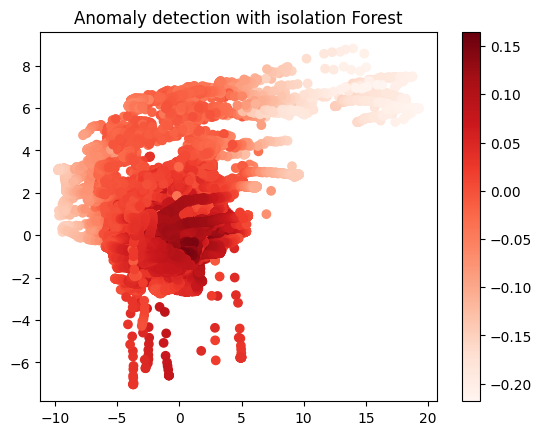

In [140]:
#plot the scatter plot
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=scores, cmap='Reds')
plt.title('Anomaly detection with isolation Forest')
plt.colorbar()
plt.show()

According to the graph, the anomalies seem to be situated in the up-right corner if we use the `scores` variable.  
We plot now with the anomalies found.

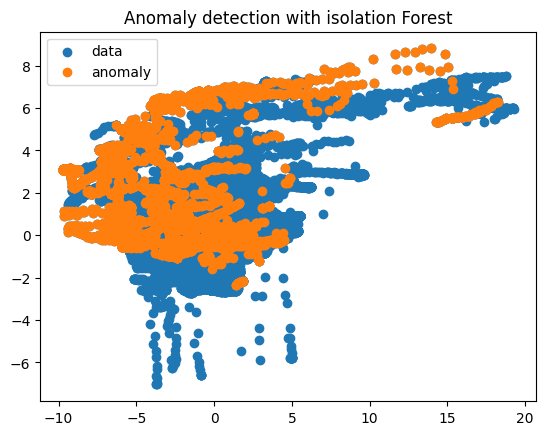

In [141]:
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], label = 'data')
plt.scatter(transformed_data[outliers_index,0], transformed_data[outliers_index,1], label = 'anomaly')
plt.title('Anomaly detection with isolation Forest')
plt.legend()
plt.show()

Thus, we can see in more details where there are situated in the graph.

Let's observe the anomalies in dimension 3.

In [142]:
# Application of PCA
pca = PCA(n_components = 3)
scaler = StandardScaler()

#Normalisation
X = scaler.fit_transform(new_df)


# Transformed data
transformed_data = pca.fit_transform(X)
transformed_data

array([[-3.93878652, -0.31638988, -0.99502282],
       [-3.95131494, -0.32309715, -1.00871175],
       [-3.9612607 , -0.36834024, -1.02620771],
       ...,
       [-3.54292937,  0.33907468,  2.31635826],
       [-3.5451518 ,  0.34325107,  2.31739904],
       [-3.54744989,  0.34302358,  2.31871407]])

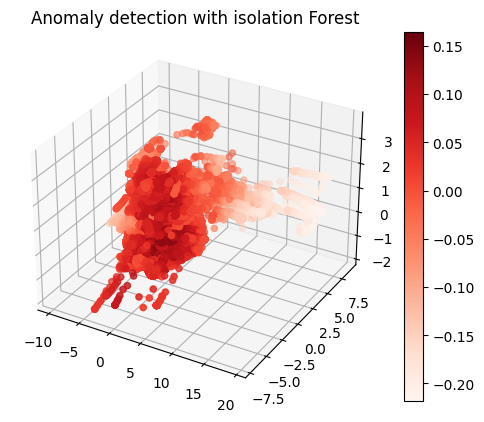

In [143]:
# plot the scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
graph = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=scores, cmap='Reds', lw = 1)
plt.title('Anomaly detection with isolation Forest')
plt.colorbar(graph)
plt.show()

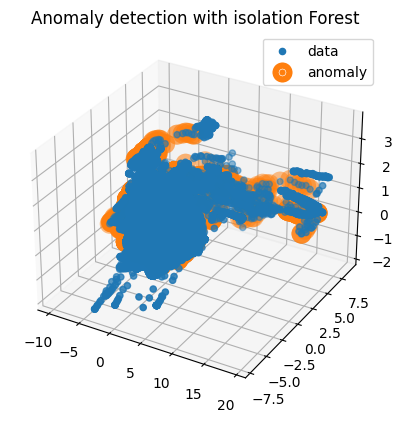

In [149]:
#With anomalies found
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], label = 'data')
ax.scatter(transformed_data[outliers_index,0], transformed_data[outliers_index,1], 
           transformed_data[outliers_index,2], label = 'anomaly', marker = 'o', lw = 10) # we increase the size of the 
plt.title('Anomaly detection with isolation Forest')
plt.legend()
plt.show()

Anomalies are hard to see because of the amount of data. But they seem to be in the main cluster.

In [157]:
#dataset with the number of anomalies by windows
outliers.groupby('day_cycle_window').count()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,anomaly
day_cycle_window,,,,,,,,,,,,
1_1_1,79,79,79,79,79,79,79,79,79,79,79,79
1_1_2,100,100,100,100,100,100,100,100,100,100,100,100
1_1_3,65,65,65,65,65,65,65,65,65,65,65,65
1_1_4,77,77,77,77,77,77,77,77,77,77,77,77
1_1_5,58,58,58,58,58,58,58,58,58,58,58,58
...,...,...,...,...,...,...,...,...,...,...,...,...
4_3_62,100,100,100,100,100,100,100,100,100,100,100,100
4_3_63,62,62,62,62,62,62,62,62,62,62,62,62
4_3_64,100,100,100,100,100,100,100,100,100,100,100,100


In [159]:
print('There are', len(outliers.groupby('day_cycle_window').count()),
'windows where there is at least one measure considered as an anomaly.')

There are 143 windows where there is at least one measure considered as an anomaly.


<h2  style = "font-size:20px; color : Green; text-align: left;">🖥️ 2.3 LocalOutlierFactor </h2>

We will now do the same steps as before, but with an other algorithm. The `LocalOutlierFactor` compare the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors. These are considered to be outliers.  
We will put the same percentage of contamination.

In [179]:
# Fit the LocalOutlierFactor model
clf = LocalOutlierFactor(n_neighbors=50, contamination=0.05, novelty = True)
clf.fit(new_df)

#Anomaly scores for each instance of the dataset
scores = clf.decision_function(new_df)


C:\Users\33666\anaconda3\envs\aibt_venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [180]:
#Prediction of if a data is an anomaly or not
y_pred = clf.predict(new_df)

# Addition of the column to the dataset with the predictions
new_df['anomaly_LOF'] = y_pred
new_df['anomaly_LOF']

C:\Users\33666\anaconda3\envs\aibt_venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


0        -1
1        -1
2        -1
3        -1
4        -1
         ..
162621    1
162622    1
162623    1
162624    1
162625    1
Name: anomaly_LOF, Length: 162200, dtype: int32

In [195]:
#dataframe with the data identified as anomaly 
outliers = new_df.loc[new_df['anomaly_LOF'] == -1]

#list of the index of the anomalies
outliers_index = list(outliers.index)
print(len(outliers_index))
print(new_df['anomaly_LOF'].value_counts())
print('We have', new_df['anomaly_LOF'].value_counts()[-1], 'anomalies identified.')


7823
 1    154377
-1      7823
Name: anomaly_LOF, dtype: int64
We have 7823 anomalies identified.


We now want to see the graph associated.

In [203]:
# Application of PCA
pca = PCA(n_components = 3)
scaler = StandardScaler()

#Normalisation
X = scaler.fit_transform(new_df)
print(len(X)) #

# Transformed data
transformed_data_LOF = pca.fit_transform(X)
print(len(transformed_data_LOF))
transformed_data_LOF

162200
162200


array([[-4.00849219e+00,  1.50787159e-01,  2.80165218e-03],
       [-4.02101899e+00,  1.44139661e-01, -1.00940953e-02],
       [-4.03095878e+00,  9.93384701e-02, -2.48840083e-02],
       ...,
       [-3.53890392e+00,  3.03629062e-01,  2.15409640e+00],
       [-3.54112672e+00,  3.07765654e-01,  2.15492533e+00],
       [-3.54342468e+00,  3.07542376e-01,  2.15622622e+00]])

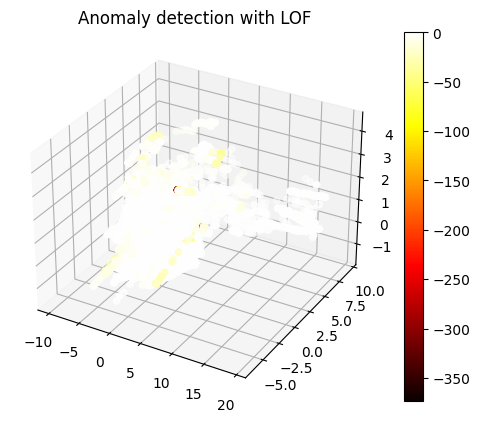

In [205]:
# plot the scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
graph = ax.scatter(transformed_data_LOF[:, 0], transformed_data_LOF[:, 1], transformed_data_LOF[:, 2], c=scores, cmap='hot', lw = 1)
plt.title('Anomaly detection with LOF')
plt.colorbar(graph)
plt.show()

In [206]:
# Application of PCA
pca = PCA(n_components = 2)
scaler = StandardScaler()

#Normalisation
X = scaler.fit_transform(new_df)

# Transformed data
transformed_data_LOF = pca.fit_transform(X)

162200


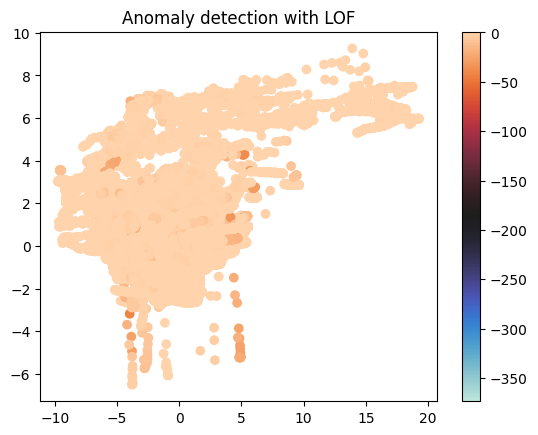

In [215]:
#plot the scatter plot
plt.scatter(transformed_data_LOF[:, 0], transformed_data_LOF[:, 1], c=scores, cmap='icefire')
plt.title('Anomaly detection with LOF')
plt.colorbar()
plt.show()

In [210]:
#dataset with the number of anomalies by windows
outliers_LOF.groupby('day_cycle_window').count()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,anomaly,anomaly_LOF
day_cycle_window,,,,,,,,,,,,,
1_1_1,6,6,6,6,6,6,6,6,6,6,6,6,6
1_1_13,15,15,15,15,15,15,15,15,15,15,15,15,15
1_1_22,17,17,17,17,17,17,17,17,17,17,17,17,17
1_1_25,6,6,6,6,6,6,6,6,6,6,6,6,6
1_1_26,8,8,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_4_86,6,6,6,6,6,6,6,6,6,6,6,6,6
4_4_87,7,7,7,7,7,7,7,7,7,7,7,7,7
4_4_9,21,21,21,21,21,21,21,21,21,21,21,21,21


In [211]:
print('There are', len(outliers_LOF.groupby('day_cycle_window').count()),
'windows where there is at least one measure considered as an anomaly.')

There are 564 windows where there is at least one measure considered as an anomaly.


In this case, we can see we have less anomalies with this algorithm compared to IsolationForest. However, much more windows areimpacted.

<h1  style = "font-size:30px; color : Blue; text-align: left;">🤔 3. Conclusion </h1>

As a DataScientist, we are  more than capable of finding anomalies in a dataset.  
But In this case, we must indicate relevants points.  
First, we don't have enough information about the dataset. So, we can't say which feature will have a more meaningful impact on a possible anomaly than the other.  
Moreover, we have tested two different algorithms. We found that :
<table>

<tr> <td></td> <td>IsolationForest</td> <td>LocalOutlierFactor</tr>

<tr> <td>Number of windows with anomalies</td> <td>143</td> <td>564</td> </tr>
<tr> <td>Number of anomalies</td> <td>8110</td> <td>7823</td> </tr>

</table>

While one has more anomalies than the other, we can see that less windows are concerned.  
Both algorithms are great for this kind of data. It's now up to the aircraft system expert to decide if he prefers to concentrate himself on a higher number of anomalies or a higher number of windows impacted by them.